In [3]:
import pandas as pd
import tarfile
import os
#Imports that are needed for the project

#from tslearn.clustering import KernelKMeans, TimeSeriesKMeans, silhouette_score
#from collections import defaultdict
#from tslearn.utils import to_time_series_dataset
#from tslearn.barycenters import softdtw_barycenter

#important libraries for the Sentiment analysis
from scipy.signal import savgol_filter
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#important libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf

from typing import Dict
import json

import pickle

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")

'''# Specify the file name (assuming it's in the same folder as your Jupyter Notebook)
file_name = 'MovieSummaries.tar.gz'

# Extract the archive to the current working directory
with tarfile.open(file_name, 'r:gz') as tar:
    tar.extractall()

# List the files in the current working directory
extracted_files = os.listdir()
print(extracted_files)'''

"# Specify the file name (assuming it's in the same folder as your Jupyter Notebook)\nfile_name = 'MovieSummaries.tar.gz'\n\n# Extract the archive to the current working directory\nwith tarfile.open(file_name, 'r:gz') as tar:\n    tar.extractall()\n\n# List the files in the current working directory\nextracted_files = os.listdir()\nprint(extracted_files)"

First of all, we need to load the data and store it in a dataframe.

In [4]:
# Define the path to the "movie.metadata.tsv" file 
DATA_FOLDER = 'data/'
MOVIE_METADATA = DATA_FOLDER+"movie.metadata.tsv"

# Load the TSV file into a DataFrame
df = pd.read_csv(MOVIE_METADATA, sep='\t')

# Now you can work with the DataFrame "df"
# Define the column names you want
column_names = ["Wikipedia Movie ID", "Freebase_Movie_ID", "Movie_name", "Movie release date",
                "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries",
                "Movie genres"]

# Set the column names of the DataFrame
df.columns = column_names 

df.head()

,Wikipedia Movie ID,Freebase_Movie_ID,Movie_name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."


We need to read the plot_summaries file (containing the movie plots) and store it in a dataframe, with the corresponding movie id. This step is useful for all the methods that we will be suing to answer our research questions, including the sentiment analysis.

In [9]:
# Read the Movie Summary Dataset
df_summaries = pd.read_csv('data/plot_summaries.txt', sep = '\t', header=None, names = ['Wikipedia Movie ID', 'summaries'])
# Display the first 5 elements of the dataframe
df_summaries.head()

,Wikipedia Movie ID,summaries
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


**1) Data wrangling for the Sentiment analysis:**

In [6]:
#NLTK often requires some additional data to be downloaded before it can be used effectively. 
#This data includes pre-trained models, corpora, and other resources that NLTK uses to perform various NLP tasks.
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/macdesarah/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/macdesarah/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/macdesarah/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/macdesarah/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/macdesarah/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    |

True

Once we have obtained our movie summaries, we start the data preprocessing for the sentiment analysis, the first step of which is to tokenize the sentences present in each movie plot. In other words, we split the summaries in separate senetences using the NTLK (natural language processing) library.
Different approaches are available for tokenization: either splitting text into separate sentences (nltk.tokenize.sent_tokenize) or into seprarate words (nltk.tokenize.word_tokenize). We chose to use the first approach, as it is more suitable for our analysis. Indeed, keeping the full sentence is important in sentiment analysis since the sentiment often depends strongly on how words are put together rather than individual words. For example, the sentence "I love this movie" has a positive sentiment, while "I do not love this movie" has a negative sentiment, even though both sentences contain the word "love". 
After splitting the summaries into sentences, we convert all the words to lowercase, so that the words "Love", "LOVE" and "love" are considered the same word. Finally, we lemmatize the words, i.e. convert them to their root form. For example, the words "loved", "loving" and "loves" will all be converted to "love". This step is important to reduce the number of unique words in our dataset.

In [20]:
# Splitting the text into individual sentences
df_summaries['summaries_tokens']= df_summaries['summaries'].apply(lambda s: tokenize.sent_tokenize(s))
df_summaries.head()

,Wikipedia Movie ID,summaries,summaries_tokenize,summaries_tokens
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[shlykov, a hard-working taxi driver and lyosh...","[Shlykov, a hard-working taxi driver and Lyosh..."
1,31186339,The nation of Panem consists of a wealthy Capi...,[the nation of panem consists of a wealthy cap...,[The nation of Panem consists of a wealthy Cap...
2,20663735,Poovalli Induchoodan is sentenced for six yea...,[poovalli induchoodan is sentenced for six ye...,[Poovalli Induchoodan is sentenced for six ye...
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[the lemon drop kid , a new york city swindler...","[The Lemon Drop Kid , a New York City swindler..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,[seventh-day adventist church pastor michael c...,[Seventh-day Adventist Church pastor Michael C...


In [21]:
# Converting to lower case
df_summaries['summaries_tokens'] = df_summaries['summaries_tokens'].apply(lambda x: [word.lower() for word in x])
df_summaries.head()

,Wikipedia Movie ID,summaries,summaries_tokenize,summaries_tokens
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[shlykov, a hard-working taxi driver and lyosh...","[shlykov, a hard-working taxi driver and lyosh..."
1,31186339,The nation of Panem consists of a wealthy Capi...,[the nation of panem consists of a wealthy cap...,[the nation of panem consists of a wealthy cap...
2,20663735,Poovalli Induchoodan is sentenced for six yea...,[poovalli induchoodan is sentenced for six ye...,[poovalli induchoodan is sentenced for six ye...
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[the lemon drop kid , a new york city swindler...","[the lemon drop kid , a new york city swindler..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,[seventh-day adventist church pastor michael c...,[seventh-day adventist church pastor michael c...


In [22]:
# Lemmatizing the words
df_summaries['summaries_tokens'] = df_summaries['summaries_tokens'].apply(lambda x: [WordNetLemmatizer().lemmatize(word) for word in x])
df_summaries.head()

,Wikipedia Movie ID,summaries,summaries_tokenize,summaries_tokens
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[shlykov, a hard-working taxi driver and lyosh...","[shlykov, a hard-working taxi driver and lyosh..."
1,31186339,The nation of Panem consists of a wealthy Capi...,[the nation of panem consists of a wealthy cap...,[the nation of panem consists of a wealthy cap...
2,20663735,Poovalli Induchoodan is sentenced for six yea...,[poovalli induchoodan is sentenced for six ye...,[poovalli induchoodan is sentenced for six ye...
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[the lemon drop kid , a new york city swindler...","[the lemon drop kid , a new york city swindler..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,[seventh-day adventist church pastor michael c...,[seventh-day adventist church pastor michael c...


Now that the preprocess is complete we can perform sentiment analysis on the different sentences. The tool that we are going to use is Vader sentiment analyzer, which is a popular tool usually used to analyze social medias. Because of that it is a tool that is used to informal and short text. 

We are going to go trough every sentences and use the Vader sentiment analyzer on every sentences. We will then obtain a sentiment scores between -1 for negative sentences and 1 for positive sentences in the continuous case. For the discrete case we have 3 cases : -1:negative, 0:neutral, 1:positive. Right now we don't know what the best way to calculate the average sentiment score for the whole plot we did it in continous and discrete case for every sentences. 

In [22]:
analyzer = SentimentIntensityAnalyzer()

# classifying in 3 classes (positive, negative, neutral)
def classify(score: float):
    #positive
    if score >= 0.05:
        return 1
    #negative
    elif score <= -0.05:
        return -1
    #neutral
    return 0

# given a list of sentances, return the result of the analyzer
def analyse_text(text, classify_discrete = True): 
    res = []
    for sentence in text:
        sentiment_result = analyzer.polarity_scores(sentence)
        if classify_discrete:
            res.append(classify(sentiment_result['compound']))
        else:
            res.append(sentiment_result['compound'])
    
    window = int(len(res)/6)
    window = window + 1 if window%2 == 0 else window 
    
    # we utilize a savgol filter, which will smooth the time series (without filtering the resultant time series might be noisy.)
    return savgol_filter(res, window_length=window, polyorder=3) if (not classify_discrete and window>3) else res

In [23]:
# Compute the plot sentitiment discrete classes and continuous scores (the two different columns described previously)
df_summaries["summaries_classification"] = df_summaries["summaries_tokenize"].apply(lambda s: analyse_text(s))
df_summaries["summaries_scores"] = df_summaries["summaries_tokenize"].apply(lambda s: analyse_text(s, classify_discrete=False))
df_summaries["number_of_sentences"] = df_summaries["summaries_tokenize"].apply(lambda s: len(s))

In [24]:
# display the first 5 elements to view the newly added columns 
df_summaries.head(5)

,Wikipedia Movie ID,summaries,summaries_tokenize,summaries_classification,summaries_scores,number_of_sentences
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a hard-working taxi driver and Lyosh...",[0],[0.0083],1
1,31186339,The nation of Panem consists of a wealthy Capi...,[The nation of Panem consists of a wealthy Cap...,"[0, -1, 1, 0, 0, -1, -1, 1, 1, 1, 0, -1, -1, 0...","[-0.22422929292929408, 0.011969191919191602, 0...",52
2,20663735,Poovalli Induchoodan is sentenced for six yea...,[Poovalli Induchoodan is sentenced for six ye...,"[-1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 0, -1, -1...","[-0.8037000000000011, 0.3468000000000012, 0.01...",26
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The Lemon Drop Kid , a New York City swindler...","[-1, 1, 1, -1, -1, 0, 0, 1, -1, -1, 1, 0, -1, ...","[-0.08758181818181576, -0.2674106060606061, -0...",49
4,595909,Seventh-day Adventist Church pastor Michael Ch...,[Seventh-day Adventist Church pastor Michael C...,"[1, 1, 1, -1, 1, 0, -1, 1, -1, -1, -1, 1, -1, ...","[0.4019, 0.0772, 0.2732, -0.6367, 0.4215, 0.0,...",15


In [25]:
# Merge the two dataframes based on the Movie Wikipedia ID
df = df.merge(df_summaries, left_on="Wikipedia Movie ID",right_on='Wikipedia Movie ID')
#df = df.drop(["summaries_classification_y", "summaries_tokenize_y","summaries_y","summaries_scores_y","number_of_sentences_y"],axis="columns")

KeyError: "['summaries_classification_y', 'summaries_tokenize_y', 'summaries_y', 'summaries_scores_y', 'number_of_sentences_y'] not found in axis"

In [26]:
display(df)
#df.rename(columns={"summaries_x": "summaries", "summaries_tokenize_x": "summaries_tokenize", "summaries_classification_x": "summaries_classification"})

,Wikipedia Movie ID,Freebase_Movie_ID,Movie_name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,summaries,summaries_tokenize,summaries_classification,summaries_scores,number_of_sentences
0,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...,[A series of murders of rich young women throu...,"[-1, 1, 1, -1, -1, -1, 0, 0, -1, -1, 1, 0, 1, ...","[-0.6641833333333452, 0.3856095238095195, 0.41...",36
1,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra...","[Eva, an upper class housewife, becomes frustr...","[-1, 0, 0, 1, 0, 0, 0, 1, -1, 1, 1, -1, -1, -1...","[-0.703019999999999, -0.2479199999999997, 0.37...",24
2,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns...","[Every hundred years, the evil Morgana return...","[-1, -1, 0, 1, 1, -1, -1]","[-0.836, -0.5106, 0.0, 0.6486, 0.3182, -0.3612...",7
3,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a...","[Adam, a San Francisco-based artist who works ...","[0, -1, 1, 0, -1, -1, 0, 0, -1]","[-0.0258, -0.3612, 0.6705, 0.0, -0.4404, -0.12...",9
4,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,[{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally ...,"[0, 1, -1]","[0.0, 0.4019, -0.1027]",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42198,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",{{plot}} The film opens with a Great Western e...,[{{plot}} The film opens with a Great Western ...,"[1, 1, -1, -1, 0, -1, -1, 0, 1, 1, -1, -1, -1,...","[0.412546001367053, 0.20288074732285152, 0.039...",114
42199,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",Two former National Oceanic Atmospheric Admini...,[Two former National Oceanic Atmospheric Admin...,"[0, 0, 1, 0, 0]","[0.0, 0.0, 0.6249, 0.0, 0.0]",5
42200,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",{{No plot}} This film follows 12 years in the ...,[{{No plot}} This film follows 12 years in the...,"[-1, -1, 1]","[-0.7845, -0.4019, 0.7269]",3
42201,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...","The story takes place in the year 2092,The Sup...","[The story takes place in the year 2092,The Su...","[1, 1, -1, 0, -1, 1, 0, -1]","[0.7351, 0.1531, -0.7003, 0.0, -0.0772, 0.296,...",8


In [27]:
def has_keyword(summary, keywords):
    for word in keywords:
        if word in summary.lower():  # Perform a case-insensitive check
            return True
    return False

In [29]:
keywords = [
    "terrorism", "terrorist", "terrorists", "jihad", "extremism", "extremist", "attacks", "attack",
    "bombs", "bombing", "bombers", "hijack", "hijacking", "kidnap", "kidnapping", "counterterrorism",
    "counterterrorist", "radicalization", "radicalized", "security threat", "political violence",
    "suicide bomber", "war on terror", "homeland security", "national security", "intelligence agencies",
    "counterinsurgency", "terrorist cells", "radical ideology", "terrorist plot", "terrorist organization",
    "hostage crisis", "terrorism investigation", "counterterrorist operation", "radical", "guerrilla warfare",
    "insurgency", "terror threat", "covert operations", "political unrest", "martyrdom", "cyberterrorism",
    "terrorism financing", "violent extremism", "terrorist recruitment", "suicide attacks",
    "terrorist sleeper cells", "counterterror measures", "clandestine activities", "security intelligence"
]
terrorism_df = df[df['summaries'].apply(lambda x: has_keyword(x, keywords))]
display(terrorism_df)

,Wikipedia Movie ID,Freebase_Movie_ID,Movie_name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,summaries,summaries_tokenize,summaries_classification,summaries_scores,number_of_sentences
13,9633533,/m/02pml15,Vandanam,1989,NaN,168.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}","Professor Kurian Fernandez , a convict escapes...","[Professor Kurian Fernandez , a convict escape...","[1, -1, 1, 0, 1, -1, 0, -1, 1, -1, -1, 1, 0, 0...","[0.07068714285714348, -0.2813485714285723, -0....",33
21,261237,/m/01mrrd,The Gods Must Be Crazy,1980,34331783.0,109.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/0hzlz"": ""South Africa""}","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",The film is a collision of three separate stor...,[The film is a collision of three separate sto...,"[1, 1, -1, 0, -1, 0, -1, -1, -1, 0, -1, 1, -1,...","[0.2732, 0.2732, -0.0772, 0.0, -0.2023, 0.0, -...",22
23,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",A Japanese businessman sees a woman being grop...,[A Japanese businessman sees a woman being gro...,"[0, 1, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 1, -1]","[0.0, 0.2732, 0.0, -0.5927, 0.0, 0.0, 0.0, 0.0...",14
29,32104837,/m/0g4zl4c,It Came Upon the Midnight Clear,1984-12-15,NaN,99.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hqxf"": ""Family Film"", ""/m/07s9rl0"": ""Dra...","The film centers on Mike Halligan, a retired c...","[The film centers on Mike Halligan, a retired ...","[-1, 1]","[-0.6705, 0.8779]",2
30,2647998,/m/07v6f3,The Human Tornado,1976,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/0hj3l_y...","After coming off a successful comedy tour, Dol...","[After coming off a successful comedy tour, Do...","[1, 0, 0, 0, -1, -1]","[0.2263, 0.0, 0.0, 0.0258, -0.34, -0.5267]",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42168,5714284,/m/0f0rqm,The Four Feathers,1939,NaN,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/02jx1"": ""England"", ""/m/07ssc"": ""United Ki...","{""/m/03k9fj"": ""Adventure"", ""/m/082gq"": ""War fi...","In 1895, the North Surrey Regiment of the Brit...","[In 1895, the North Surrey Regiment of the Bri...","[0, -1, -1, -1, 1, -1, 0, -1, 0, 1, -1, -1, -1...","[-0.0573814285714289, -0.41907428571428584, -0...",26
42192,19286279,/m/04ldgm4,Kalai Arasi,1963-04-19,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film"", ""/m/02kdv5l"": ""A...",Kalai Arasi' is a well-blended story of romanc...,[Kalai Arasi' is a well-blended story of roman...,"[1, 1, 1, 1, 1, 0, 0, -1, -1, 1, 0, -1, 1, 0, ...","[0.5326952380952383, 0.5717976190476189, 0.562...",40
42196,15394941,/m/03m6zh4,Gopi Kishan,1994-12-02,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama"", ""/m/02kdv5l"": ""Action""...",Kishan killed a man in his childhood when the...,[Kishan killed a man in his childhood when th...,"[-1, -1, -1, 1, 0, 1, -1, 0, 1, -1, -1, -1, 0,...","[-0.9783929292929319, -0.3564762626262632, -0....",55
42198,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",{{plot}} The film opens with a Great Western e...,[{{plot}} The film opens with a Great Western ...,"[1, 1, -1, -1, 0, -1, -1, 0, 1, 1, -1, -1, -1,...","[0.412546001367053, 0.20288074732285152, 0.039...",114


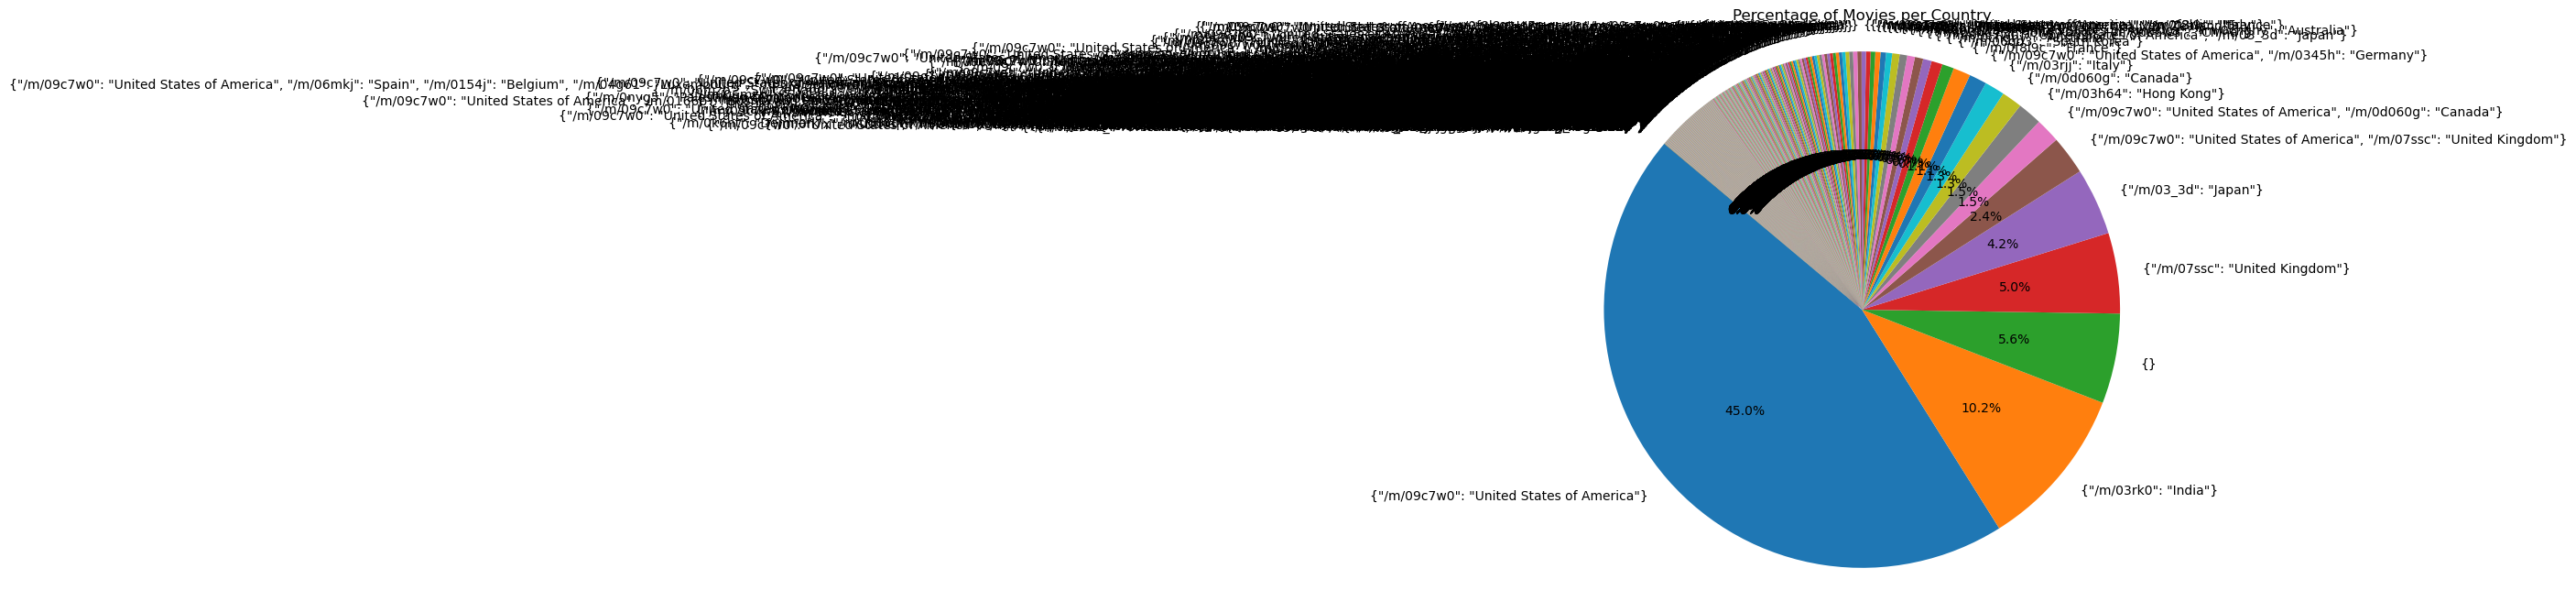

In [30]:
country_counts = terrorism_df['Movie countries'].value_counts()
# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Movies per Country')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.show()

<Axes: ylabel='Movie countries'>

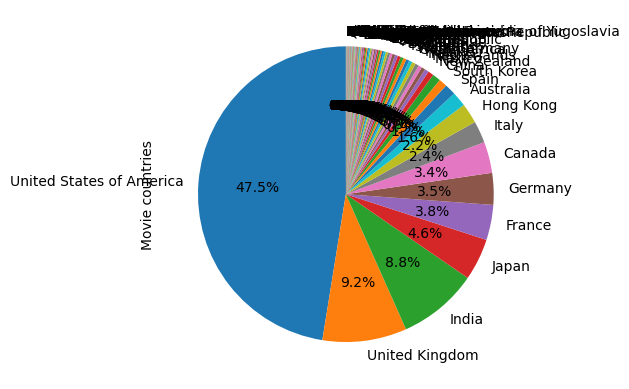

In [32]:
# Splitting entries with multiple countries in 'country' column
filtered_movies = terrorism_df.copy()
filtered_movies['Movie countries'] = filtered_movies['Movie countries'].apply(lambda x: list(eval(x).values()) if isinstance(x, str) else [x])

# Explode the lists into separate rows for each country
exploded = filtered_movies.explode('Movie countries')

# Count occurrences of each country
country_counts = exploded['Movie countries'].value_counts()

# Plotting the pie chart
country_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)


In [33]:
#sadness emotion
sadness_keywords = [
    'sadness', 'sorrow', 'grief', 'depression', 'despair', 'heartache', 'melancholy', 'misery', 'lament', 'ache',
    'woeful', 'desolate', 'gloomy', 'doleful', 'blue', 'mournful', 'downhearted', 'tragic', 'dejected', 'somber',
    'tearful', 'forlorn', 'heavy-hearted', 'grieving', 'dismal', 'dismay', 'hopeless', 'pain', 'wistful', 'regret',
    'agony', 'disheartened', 'weeping', 'distressed', 'miserable', 'sullen', 'lamentation', 'moody', 'wretched',
    'cheerless', 'sombre', 'funereal', 'grim', 'lugubrious', 'hurt', 'bereaved', 'woe', 'anguished',
    'cheerless', 'gloomy', 'lamentation', 'funereal', 'lugubrious', 'agonized', 'mourn', 'aching'
]
movies = terrorism_df.copy()
sad_movies = movies[movies['summaries'].apply(lambda x: has_keyword(x, sadness_keywords))]

In [55]:
print(f"We have {len(sad_movies)} sad movies")

We have 4048 sad movies


In [57]:
sad_movies.head()

,Wikipedia Movie ID,Freebase_Movie_ID,Movie_name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,summaries,summaries_tokenize,summaries_classification,summaries_scores,number_of_sentences
13,9633533,/m/02pml15,Vandanam,1989,NaN,168.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}","Professor Kurian Fernandez , a convict escapes...","[Professor Kurian Fernandez , a convict escape...","[1, -1, 1, 0, 1, -1, 0, -1, 1, -1, -1, 1, 0, 0...","[0.07068714285714348, -0.2813485714285723, -0....",33
21,261237,/m/01mrrd,The Gods Must Be Crazy,1980,34331783.0,109.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/0hzlz"": ""South Africa""}","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",The film is a collision of three separate stor...,[The film is a collision of three separate sto...,"[1, 1, -1, 0, -1, 0, -1, -1, -1, 0, -1, 1, -1,...","[0.2732, 0.2732, -0.0772, 0.0, -0.2023, 0.0, -...",22
93,748616,/m/03813g,"Spring, Summer, Fall, Winter... and Spring",2003-08-14,9524745.0,95.0,"{""/m/02hwhyv"": ""Korean Language""}","{""/m/06qd3"": ""South Korea"", ""/m/0345h"": ""Germa...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...","The film is divided into five segments , each ...","[The film is divided into five segments , each...","[0, 0, 1, 0, 1, 0, 1, -1, -1, 0, 1, 1, -1, 0, ...","[-0.04920714285714467, 0.17610476190476138, 0....",47
111,103021,/m/0p_sc,Midnight Express,1978-08-31,35000000.0,121.0,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0hn10"": ""LGBT"", ...","On October 6, 1970, while on holiday in Istanb...","[On October 6, 1970, while on holiday in Istan...","[1, -1, -1, 0, 1, 1, -1, -1, -1, -1, -1, 1, -1...","[0.058778571428580124, -0.49572619047618527, -...",43
112,33144131,/m/0gfrkw7,Fly Away,2010,NaN,80.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...","It’s midnight, and Jeanne is awakened by wail...","[It’s midnight, and Jeanne is awakened by wai...","[-1, 0, -1, -1, 0, -1, 1, 1, -1, -1, 1, -1, 1,...","[-0.45804685314685295, -0.3843622377622378, -0...",63


In [35]:
#surprise emotion 
surprise_keywords = [
    'surprise', 'amazement', 'astonishment', 'awe', 'shocked', 'wonder', 'startled', 'stunned', 'astounded', 'shock',
    'dumbfounded', 'jolt', 'unbelievable', 'incredulous', 'stupefied', 'bewildered', 'dazed', 'disbelief', 'astonished',
    'gasp', 'overwhelmed', 'taken aback', 'flabbergasted', 'aghast', 'speechless', 'unforeseen', 'unexpected',
    'astounding', 'incredible', 'mind-blowing', 'eye-opening', 'staggering', 'unexpected', 'surprised', 'unanticipated',
    'sudden', 'wonderment', 'jarring', 'shattering', 'unforeseen', 'stunning', 'stupendous', 'jaw-dropping',
    'awe-inspiring', 'startling', 'impressive', 'extraordinary', 'remarkable', 'unforeseen', 'startling', 'shattering',
    'unpredictable', 'unforeseen', 'awe-struck', 'impressed', 'unplanned', 'amazing', 'suddenness'
]
surprise_movies = movies[movies['summaries'].apply(lambda x: has_keyword(x, surprise_keywords))]

In [58]:
print(f"We have {len(surprise_movies)} surprise movies")
surprise_movies.head(2)

We have 3204 sad movies


,Wikipedia Movie ID,Freebase_Movie_ID,Movie_name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,summaries,summaries_tokenize,summaries_classification,summaries_scores,number_of_sentences
41,5894429,/m/0fc8w8,Closing the Ring,2007-09-14,NaN,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...","The film opens in 1991, with the funeral of a ...","[The film opens in 1991, with the funeral of a...","[-1, 1, 1, 1, 1, 1, 1, -1, 0, -1, 0, 0, 1, 1, 1]","[-0.7506, 0.5994, 0.25, 0.7906, 0.6369, 0.6808...",15
59,164387,/m/015wmg,...And Justice for All,1979-06-29,33300000.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",Arthur Kirkland is a hotheaded but idealistic...,[Arthur Kirkland is a hotheaded but idealisti...,"[1, -1, -1, 0, 1, -1, 1, -1, 1, -1, -1, -1, 0,...","[0.49663809523810104, -0.3700261904761884, -0....",45


In [38]:
#happiness movies
happiness_keywords = [
    'joy', 'happiness', 'delight', 'bliss', 'cheer', 'gladness', 'elation', 'euphoria', 'ecstasy', 'jubilation',
    'triumph', 'contentment', 'satisfaction', 'glee', 'serenity', 'exhilaration', 'merriment', 'enjoyment', 'thrill',
    'felicity', 'euphoric', 'lighthearted', 'overjoyed', 'radiant', 'buoyant', 'elated', 'uplifted', 'sunny', 'joyful',
    'gratification', 'jolly', 'blithe', 'ecstatic', 'spirited', 'zestful', 'carefree', 'vibrant', 'mirth', 'gaiety',
    'pleasure', 'rejoicing', 'entertainment', 'amusement', 'exuberant', 'glad', 'thrilled', 'upbeat', 'pleased',
    'ecstatic', 'mirthful', 'radiant', 'jubilant', 'upbeat', 'contented', 'pleasurable', 'exuberant'
]
happiness_movies = movies[movies['summaries'].apply(lambda x: has_keyword(x, happiness_keywords))]

In [59]:
print(f"We have {len(happiness_movies)} happiness movies")
happiness_movies.head(2)

We have 2560 happiness movies


,Wikipedia Movie ID,Freebase_Movie_ID,Movie_name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,summaries,summaries_tokenize,summaries_classification,summaries_scores,number_of_sentences
21,261237,/m/01mrrd,The Gods Must Be Crazy,1980,34331783.0,109.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/0hzlz"": ""South Africa""}","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",The film is a collision of three separate stor...,[The film is a collision of three separate sto...,"[1, 1, -1, 0, -1, 0, -1, -1, -1, 0, -1, 1, -1,...","[0.2732, 0.2732, -0.0772, 0.0, -0.2023, 0.0, -...",22
59,164387,/m/015wmg,...And Justice for All,1979-06-29,33300000.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",Arthur Kirkland is a hotheaded but idealistic...,[Arthur Kirkland is a hotheaded but idealisti...,"[1, -1, -1, 0, 1, -1, 1, -1, 1, -1, -1, -1, 0,...","[0.49663809523810104, -0.3700261904761884, -0....",45


In [40]:
#fear emotion
fear_keywords = [
    'terror', 'fear', 'fright', 'panic', 'dread', 'horror', 'anxiety', 'worry', 'apprehension', 'trepidation',
    'nervousness', 'scared', 'awe', 'phobia', 'spine-chilling', 'petrified', 'terrified', 'horrified', 'alarmed',
    'startled', 'creepy', 'shivery', 'timid', 'anxious', 'panicky', 'hysteria', 'creeped out', 'jittery', 'dismay',
    'uneasy', 'frightened', 'spooked', 'eerie', 'haunting', 'apprehensive', 'scary', 'chilling', 'menacing',
    'hysterical', 'foreboding', 'tense', 'panic-stricken', 'shocked', 'unnerved', 'terrifying', 'shuddery', 'afraid',
    'unsettled', 'fainthearted', 'cowardly', 'tremulous', 'distressed', 'anxiousness'
]
fear_movies = movies[movies['summaries'].apply(lambda x: has_keyword(x, fear_keywords))]

In [60]:
print(f"We have {len(fear_movies)} fear movies")
fear_movies.head(2)

We have 3807 fear movies


,Wikipedia Movie ID,Freebase_Movie_ID,Movie_name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,summaries,summaries_tokenize,summaries_classification,summaries_scores,number_of_sentences
21,261237,/m/01mrrd,The Gods Must Be Crazy,1980,34331783.0,109.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/0hzlz"": ""South Africa""}","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",The film is a collision of three separate stor...,[The film is a collision of three separate sto...,"[1, 1, -1, 0, -1, 0, -1, -1, -1, 0, -1, 1, -1,...","[0.2732, 0.2732, -0.0772, 0.0, -0.2023, 0.0, -...",22
23,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",A Japanese businessman sees a woman being grop...,[A Japanese businessman sees a woman being gro...,"[0, 1, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 1, -1]","[0.0, 0.2732, 0.0, -0.5927, 0.0, 0.0, 0.0, 0.0...",14


In [42]:
#anger emotion
anger_keywords = [
    'rage', 'fury', 'irate', 'outrage', 'indignation', 'angry', 'enraged', 'wrath', 'hostility', 'fuming',
    'infuriated', 'resentment', 'temper', 'agitated', 'seething', 'vexed', 'frustration', 'riled up', 'livid',
    'annoyed', 'bitterness', 'mad', 'displeasure', 'fuming', 'peeved', 'irritated', 'provoked', 'ticked off', 'riled',
    'irritation', 'disgust', 'repulsion', 'loathing', 'revulsion', 'abhorrence', 'odious', 'repugnance', 'sickened',
    'hate', 'disdain', 'contempt', 'aversion', 'abomination', 'appalled', 'detestation', 'grossed out', 'sickening',
    'horrified', 'abominable', 'discontent', 'hostile', 'vindictive', 'exasperation', 'outraged', 'exasperated', 'disgruntled'
]
anger_movies = movies[movies['summaries'].apply(lambda x: has_keyword(x, anger_keywords))]

In [62]:
print(f"We have {len(anger_movies)} anger movies")
anger_movies.head(2)

We have 4304 anger movies


,Wikipedia Movie ID,Freebase_Movie_ID,Movie_name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,summaries,summaries_tokenize,summaries_classification,summaries_scores,number_of_sentences
13,9633533,/m/02pml15,Vandanam,1989,NaN,168.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}","Professor Kurian Fernandez , a convict escapes...","[Professor Kurian Fernandez , a convict escape...","[1, -1, 1, 0, 1, -1, 0, -1, 1, -1, -1, 1, 0, 0...","[0.07068714285714348, -0.2813485714285723, -0....",33
23,4951456,/m/0cws46,Kinjite: Forbidden Subjects,1989,3416846.0,97.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",A Japanese businessman sees a woman being grop...,[A Japanese businessman sees a woman being gro...,"[0, 1, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 1, -1]","[0.0, 0.2732, 0.0, -0.5927, 0.0, 0.0, 0.0, 0.0...",14


In [44]:
#disgust movies
disgust_keywords = [
    'disgust', 'repulsion', 'loathing', 'revulsion', 'abhorrence', 'odious', 'repugnance', 'sickened', 'hate',
    'disdain', 'contempt', 'aversion', 'abomination', 'appalled', 'detestation', 'grossed out', 'sickening',
    'horrified', 'abominable', 'discontent', 'hostile', 'vindictive', 'exasperation', 'outraged', 'exasperated',
    'disgruntled', 'nausea', 'revolted', 'yucky', 'offensive', 'displeasure', 'repellent', 'rancid', 'vile',
    'despicable', 'dislike', 'repelling', 'icky', 'turn-off', 'disapproving', 'aberrant', 'foul', 'atrocious',
    'disgusting', 'despise', 'unpleasant', 'repellent', 'revolting', 'loathsome', 'abhorrent', 'off-putting',
    'revolting', 'contemptible', 'abominate', 'disinclined', 'abhor', 'distasteful', 'outrageous', 'fetid',
    'unpalatable', 'frightful', 'sickening', 'vomitous', 'heinous', 'horrifying', 'appalling', 'disgustful'
]
disgust_movies = movies[movies['summaries'].apply(lambda x: has_keyword(x, disgust_keywords))]

In [63]:
print(f"We have {len(disgust_movies)} disgust movies")
disgust_movies.head(2)

We have 1708 disgust movies


,Wikipedia Movie ID,Freebase_Movie_ID,Movie_name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,summaries,summaries_tokenize,summaries_classification,summaries_scores,number_of_sentences
13,9633533,/m/02pml15,Vandanam,1989,NaN,168.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}","Professor Kurian Fernandez , a convict escapes...","[Professor Kurian Fernandez , a convict escape...","[1, -1, 1, 0, 1, -1, 0, -1, 1, -1, -1, 1, 0, 0...","[0.07068714285714348, -0.2813485714285723, -0....",33
59,164387,/m/015wmg,...And Justice for All,1979-06-29,33300000.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",Arthur Kirkland is a hotheaded but idealistic...,[Arthur Kirkland is a hotheaded but idealisti...,"[1, -1, -1, 0, 1, -1, 1, -1, 1, -1, -1, -1, 0,...","[0.49663809523810104, -0.3700261904761884, -0....",45


Text(0.04, 0.5, 'Sentiment Value')

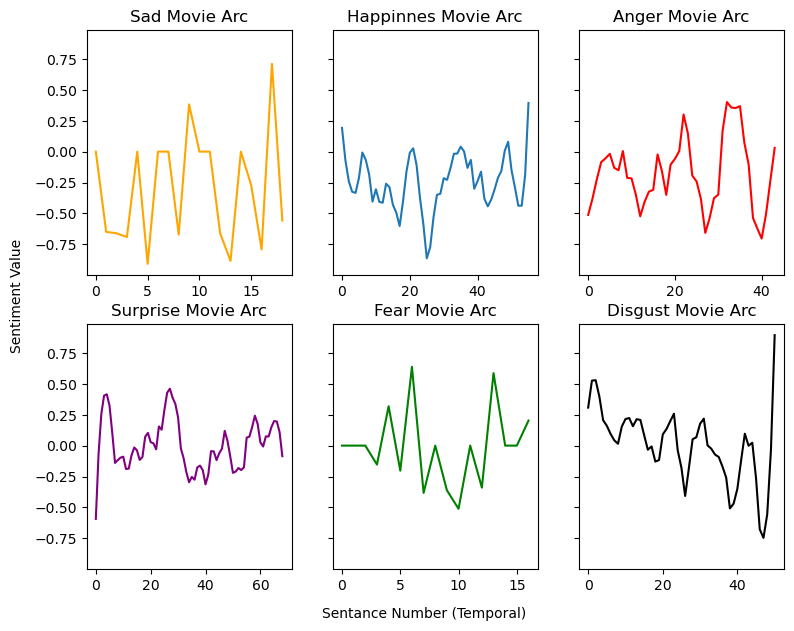

In [51]:
# now let us visualize different movie arcs for each genre (a sample from each)
fig, axis = plt.subplots(2,3, figsize=(9,7), sharey=True)
# plot the random movie arc
axis[0,0].plot(list(sad_movies.iloc[67]["summaries_scores"]), color="orange")
axis[0,0].set_title("Sad Movie Arc")

axis[0,1].plot(list(happiness_movies.iloc[88]["summaries_scores"]))
axis[0,1].set_title("Happinnes Movie Arc")

axis[1,0].plot(list(surprise_movies.iloc[12]["summaries_scores"]), color="purple")
axis[1,0].set_title("Surprise Movie Arc")

axis[1,1].plot(list(fear_movies.iloc[10]["summaries_scores"]), color="green")
axis[1,1].set_title("Fear Movie Arc")

axis[0,2].plot(list(anger_movies.iloc[67]["summaries_scores"]), color="red")
axis[0,2].set_title("Anger Movie Arc")

axis[1,2].plot(list(disgust_movies.iloc[7]["summaries_scores"]), color="black")
axis[1,2].set_title("Disgust Movie Arc")

fig.text(0.5, 0.04, "Sentance Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")

In [65]:
#We need to find a way to extract the genres
len(terrorism_df["Movie genres"].unique())

5571